Efficient Net Initial Implementation


In [0]:
# Show installed modules
# !pip freeze 

In [0]:
# Required Modules
!pip install efficientnet

# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive/')
# drive.mount("/content/drive", force_remount=True)


from keras.applications.imagenet_utils import decode_predictions
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread


from efficientnet.keras import EfficientNetB0
from efficientnet.keras import center_crop_and_resize, preprocess_input

from keras import models
from keras import layers
from keras import optimizers
from keras.callbacks import ModelCheckpoint

% cd ~
%cd /content/drive/My Drive/Thesis Papers/ISIC_Data/Training_224
!ls

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


Using TensorFlow backend.


/root
/content/drive/My Drive/Thesis Papers/ISIC_Data/Training_224
Class_dir  EfficientB0_models  Training_224  Train_val_224  Train_val_224.zip


In [0]:
# Create the class folders in google drive

# import os
# import pandas as pd
# from shutil import copyfile


# parent_dir = '/content/drive/My Drive/Thesis Papers/ISIC_Data/'
# with os.scandir(parent_dir + 'Training_224/Training_224') as entries:
#   training_gt = pd.read_csv(parent_dir + "ISIC_2019_Training_GroundTruth.csv")

#   # print(training_gt.iloc[0,0])
#   for entry in entries:
#     filename = parent_dir+'Training_224/Training_224/'+entry.name

#     # Get the row from the dataframe that corresponds to the image
#     row = training_gt.loc[training_gt['image'] == entry.name.split('.')[0]]
#     classname = str(row.columns[(row == 1).iloc[0]][0])
#     # Create the class folders
#     os.makedirs(parent_dir+'Training_224/'+ classname, exist_ok=True)
#     copyfile(filename, parent_dir+'Training_224/'+ classname +"/" + entry.name)
#     # print(row.columns[(row == 1).iloc[0]])

# Test Image

Class_dir  EfficientB0_models  Training_224  Train_val_224  Train_val_224.zip


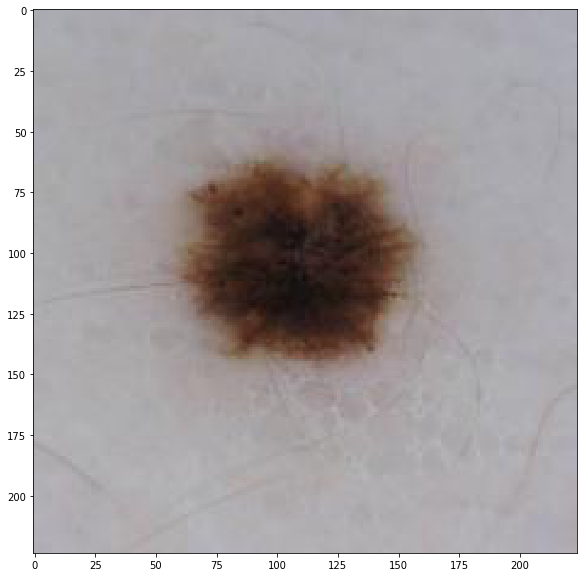

In [0]:
!ls
# test image
image = imread('Training_224/ISIC_0000001.jpg')

plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.show()

# HyperParameters

In [0]:
batch_size = 48

width = 224
height = 224
epochs = 22
dropout_rate = 0.2
input_shape = (height, width, 3)


# Create Data Generators

In [0]:
!ls
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import class_weight
import numpy as np

train_dir = "Class_dir"
# validation_dir = "Train_val_224/Validation"

train_datagen = ImageDataGenerator(
      rescale=1./255,
      validation_split=0.2) # Construct the validation set from the initial class folders

## Note that the validation data should not be augmented!
# test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        batch_size=batch_size,
        target_size=(height, width),
        # Since we use categorical_crossentropy loss, we need categorical labels
        class_mode='categorical',
        subset='training')

validation_generator = train_datagen.flow_from_directory(
        train_dir,
        batch_size=batch_size,
        target_size=(height, width),
        class_mode='categorical',
        subset='validation')


# # Compute the weight of each class
class_weights = class_weight.compute_class_weight(
               'balanced',
                np.unique(train_generator.classes), 
                train_generator.classes)

# Construct the weights dictionary to pass in the fit_generator method
class_weights_dict = {}
for i in range(len(class_weights)):
  class_weights_dict[i]=class_weights[i]


Class_dir  EfficientB0_models  Training_224  Train_val_224  Train_val_224.zip
Found 20261 images belonging to 8 classes.
Found 5060 images belonging to 8 classes.


# Import Base Model

In [0]:
conv_base = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)












Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
16809984/16804768 [==============================] - 3s 0us/step


To create our own classification layers stack on top of the EfficientNet convolutional base model. We adapt GlobalMaxPooling2D to convert 4D the (batch_size, rows, cols, channels) tensor into 2D tensor with shape (batch_size, channels). GlobalMaxPooling2D results in a much smaller number of features compared to the Flatten layer, which effectively reduces the number of parameters. 

In [0]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalMaxPooling2D(name="gap"))
# model.add(layers.Flatten(name="flatten"))
# if dropout_rate > 0:
#     model.add(layers.Dropout(dropout_rate, name="dropout_out"))
# model.add(layers.Dense(256, activation='relu', name="fc1"))
model.add(layers.Dense(8, activation='softmax', name="fc_out"))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b0 (Model)      (None, 7, 7, 1280)        4049564   
_________________________________________________________________
gap (GlobalMaxPooling2D)     (None, 1280)              0         
_________________________________________________________________
fc_out (Dense)               (None, 8)                 10248     
Total params: 4,059,812
Trainable params: 4,017,796
Non-trainable params: 42,016
_________________________________________________________________


In [0]:
print('This is the number of trainable layers '
      'before freezing the conv base:', len(model.trainable_weights))

# conv_base.trainable = False

print('This is the number of trainable layers '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable layers before freezing the conv base: 213
This is the number of trainable layers after freezing the conv base: 213


# Train the EfficientB0 model

In [0]:

# Configure how to train the model
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=0.01),
              metrics=['acc'])

# Save the model after a set number of epochs
checkpoint = ModelCheckpoint('./EfficientB0_models/full_'+str(height)+'_'+str(batch_size)+'_'+str(epochs)+"_imbalanced"+".h5", 
                             monitor='val_loss',save_best_only=True, verbose=1, mode='min', period=1)

# Train the model
# history = model.fit_generator(
#       train_generator,
#       steps_per_epoch= train_generator.samples // batch_size,
#       epochs=epochs,
#       validation_data=validation_generator,
#       validation_steps= validation_generator.samples // batch_size,
#       verbose=1,
#       callbacks = [checkpoint],
#       class_weight=class_weights_dict)


# Train the model
history = model.fit_generator(
      train_generator,
      steps_per_epoch= train_generator.samples // batch_size,
      epochs=epochs,
      validation_data=validation_generator,
      validation_steps= validation_generator.samples // batch_size,
      verbose=1,
      callbacks = [checkpoint])

Epoch 1/22
  9/422 [..............................] - ETA: 3:19:49 - loss: 6.2515 - acc: 0.3727

/usr/local/lib/python3.6/dist-packages/keras/utils/data_utils.py:610: UserWarning: The input 79 could not be retrieved. It could be because a worker has died.
  UserWarning)


 17/422 [>.............................] - ETA: 3:12:10 - loss: 5.3615 - acc: 0.3958

KeyboardInterrupt: ignored

In [0]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_x = range(len(acc))

plt.plot(epochs_x, acc, 'bo', label='Training acc')
plt.plot(epochs_x, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs_x, loss, 'bo', label='Training loss')
plt.plot(epochs_x, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Save the EfficientNEt B0 Model

In [0]:
import os
os.makedirs("./EfficientB0_models", exist_ok=True)
model.save('./EfficientB0_models/full_final_'+str(height)+'_'+str(batch_size)+'_'+str(epochs)+"_balanced"+".h5")